# Triangular Heisenberg model

The Heisenberg model on the triangular lattice is much more difficult compared to the square case. In this tutorial, we will show how to search for its ground state in Quantax.

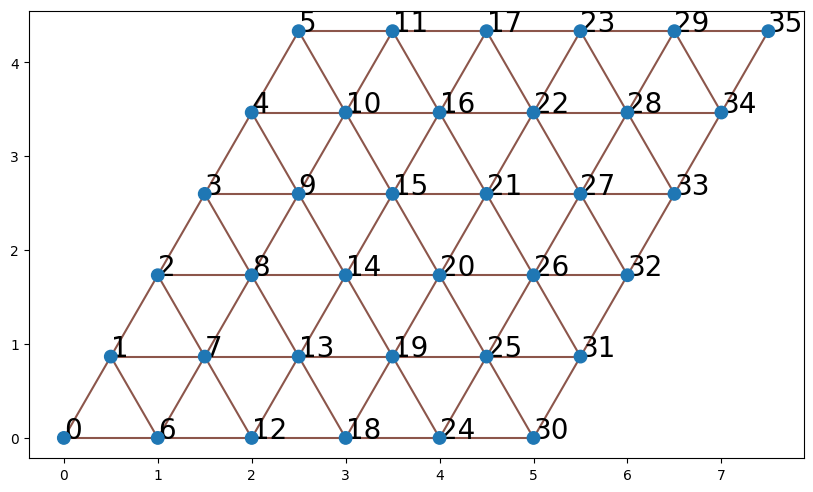

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import quantax as qtx
from IPython.display import clear_output

lattice = qtx.sites.Triangular(6, Nparticles=(18, 18))
N = lattice.Nsites

lattice.plot()
plt.show()

## Sign (phase) structure

Similar to the square Heisenberg model, the first step is to find the sign structure of ground state wavefunctions. Unfortunately, the triangular Heisenberg model is frustrated and its sign structure is unknown. Nevertheless, one can still look at its classical counterpart for a reasonable starting point.

![Classical triangular spins](../images/triangular.png)

The classical ground state has the Neel $120^\circ$ pattern as shown above. We can construct a corresponding quantum product state $\ket{\Psi_0} = \bigotimes_j \ket{\psi_j}$. The single-spin state on each site $j$ is

$$
\ket{\psi_j} = \ket{\uparrow} + e^{i\phi_j} \ket{\downarrow},
$$

where $\phi_j = 0, 2\pi/3$ or $4\pi/3$ depending on the sublattice of $j$.

$\braket{s|\Psi_0}$ provides a good reference phase structure for any input spin configuration $s$. It also suggests that expressing the wavefunction amplitudes by complex numbers is more natural. To activate complex numbers in Quantax, one should set the default dtype before any computation.

In [2]:
qtx.set_default_dtype(jnp.complex128)

We can manually define a function for this phase structure. In Quantax, we also provide a pre-defined function {py:function}`~quantax.nn.neel120_phase`.

In [3]:
def get_phase(s):
    Lx, Ly = lattice.shape[1:]
    sublattice_idx_x = jnp.arange(Lx) % 3
    sublattice_idx_y = -jnp.arange(Ly) % 3
    sublattice_idx = sublattice_idx_x[:, None] + sublattice_idx_y[None, :]
    sublattice_idx = sublattice_idx.flatten() % 3

    phase = jnp.exp(1j * sublattice_idx * 2 * jnp.pi / 3)
    phase = jnp.where(s > 0, 1.0, phase)
    return jnp.prod(phase)

s = qtx.utils.rand_states()
phase1 = get_phase(s)
phase2 = qtx.nn.neel120_phase(s)
assert jnp.isclose(phase1, phase2)

## Define model

![Residual convolutional network](../images/ResConv_triangular.svg)

We will utilize a residual convoluional network as shown above. The pair complex function in the end converts real values from previous layers to complex outputs. In {py:class}`~quantax.model.ResConv`, this pair complex function is called automatically when one needs complex outputs.

In [4]:
model0 = qtx.model.ResConv(
    nblocks=4, channels=8, kernel_size=3, dtype=jnp.float32, out_dtype=jnp.complex128
)

print("Network type:", type(model0))
print("Number of layers:", len(model0.layers))

Network type: <class 'quantax.nn.modules.Sequential'>
Number of layers: 7


Then how to include the reference phase structure? `model0` is a {py:class}`~quantax.nn.Sequential` network that performs forward pass layer by layer, so one can append a new layer to multiply the network output by a phase structure factor.

In [5]:
class PhaseLayer(qtx.nn.RawInputLayer):
    def __call__(self, x: jax.Array, s: jax.Array) -> jax.Array:
        phase = qtx.nn.neel120_phase(s)
        return x * phase

layers = model0.layers + (PhaseLayer(),)
model = qtx.nn.Sequential(layers)

Here we define the new layer to be an instance of {py:class}`~quantax.nn.RawInputLayer`, which allows it to take two inputs, the output from last layer x, and the original input spin configuration s. `Sequential` will pass x and s to `RawInputLayer` automatically. 

Here we perform a forward pass to check whether the network works. The scatter plot shows the distribution of output wavefunctions $\psi(s)$, in which the color represents the reference phase of the inputs. 

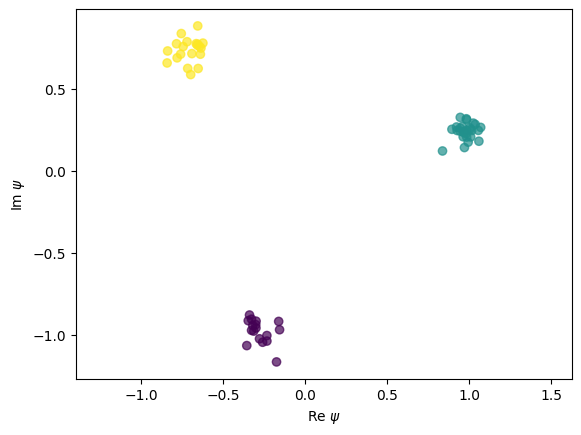

In [6]:
s = qtx.utils.rand_states(64)
psi = jax.vmap(model)(s)
phase = jax.vmap(qtx.nn.neel120_phase)(s)

plt.scatter(psi.real, psi.imag, c=jnp.angle(phase), cmap="viridis", alpha=0.7)
plt.axis("equal")
plt.xlabel(r"Re $\psi$")
plt.ylabel(r"Im $\psi$")
plt.show()

Before training, the reference phase structure dominates the output.

## Optimization

We can train this model as we have done previous tutorials.

In [7]:
H = qtx.operator.Heisenberg()
E_exact = -80.6937689612426

state = qtx.state.Variational(model, max_parallel=32768)
sampler = qtx.sampler.SpinExchange(state, nsamples=1024)
optimizer = qtx.optimizer.SR(state, H)

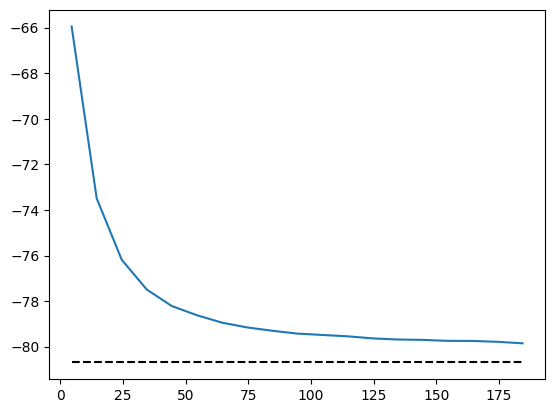

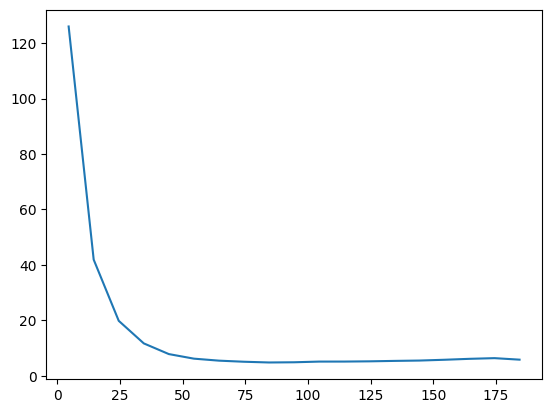

In [8]:
energy = qtx.utils.DataTracer()
VarE = qtx.utils.DataTracer()

training_rate = 5e-3

for i in range(200):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    state.update(step * training_rate)

    energy.append(optimizer.energy)
    VarE.append(optimizer.VarE)
    if i % 10 == 0:
        clear_output()
        energy.plot(batch=10, baseline=E_exact)
        plt.show()
        VarE.plot(batch=10)
        plt.show()

state.save("/tmp/triangular.eqx")

Now we can symmetrize the wavefunction. The symmetry consists of a {py:class}`~quantax.symmetry.D6` group (including rotations and mirror flips) and local spin inverse. By default, the center of transformations like rotations is fixed at the center of the lattice. In this special case, however, we need to specify the center to be (0, 0) to ensure that the lattice transforms back to itself under rotation and periodic shifts.

In [9]:
from quantax.symmetry import D6, SpinInverse

symm = D6(center=(0, 0)) @ SpinInverse()

Then we can keep training the symmetrized state.

In [10]:
symm_state = qtx.state.Variational(
    model, "/tmp/triangular.eqx", symm, max_parallel=2048
)

sampler = qtx.sampler.SpinExchange(symm_state, nsamples=1024)
optimizer = qtx.optimizer.SR(symm_state, H)

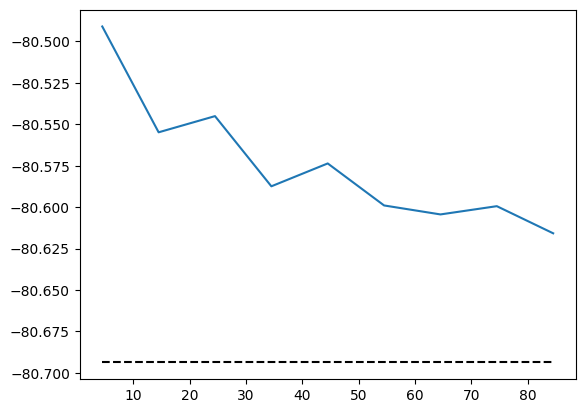

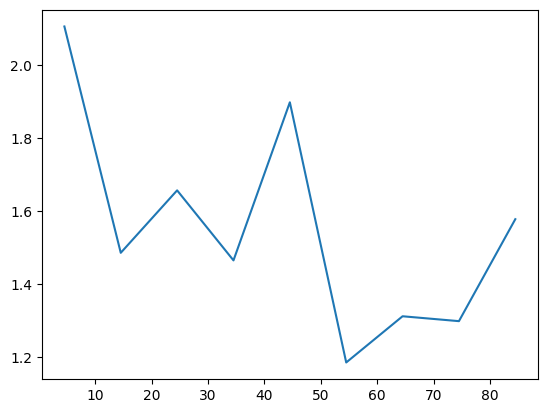

In [ ]:
energy = qtx.utils.DataTracer()
VarE = qtx.utils.DataTracer()

training_rate = 5e-3

for i in range(100):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    symm_state.update(step * training_rate)

    energy.append(optimizer.energy)
    VarE.append(optimizer.VarE)
    if i % 10 == 0:
        clear_output()
        energy.plot(batch=10, baseline=E_exact)
        plt.show()
        VarE.plot(batch=10)
        plt.show()

symm_state.save("/tmp/triangular.eqx")

Let's check how the phase structure changes after optimization.

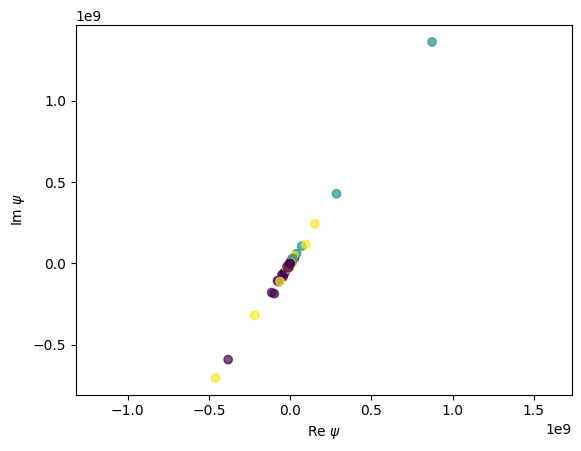

In [13]:
s = qtx.utils.rand_states(64)
psi = symm_state(s)
phase = jax.vmap(qtx.nn.neel120_phase)(s)

plt.scatter(psi.real, psi.imag, c=jnp.angle(phase), cmap="viridis", alpha=0.7)
plt.axis("equal")
plt.xlabel(r"Re $\psi$")
plt.ylabel(r"Im $\psi$")
plt.show()

There are two interesting phenomena in this plot.

1. The wavefunctions lie on the same line in the complex plane, so they become nearly real after multiplying a constant phase. This is because the ground state wavefunctions should be real in this system.

2. The new sign structure after optimization is quite different from the initial reference phase we show above.

These results prove that neural quantum states can approximate the true ground state even if the initialization is far from the target state.